In [1]:
import numpy as np
import glob, os
import xarray as xr
import pandas as pd
import time, datetime, calendar, pytz
from scipy.ndimage import median_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from copy import copy
import shapely.geometry as sgeom
import seaborn as sns
from scipy.stats import ttest_ind, ks_2samp
from sklearn.neighbors import KernelDensity
%matplotlib inline

In [2]:
rootdir = '/pscratch/sd/f/feng045/iclass/amazon_hvmixing/'

dir_w1 = f'{rootdir}CONTROLRUN/TRACK_DIR_REGRID/stats/'
dir_w2 = f'{rootdir}HVMIXINGRUN10/TRACK_DIR_REGRID/stats/'
dir_w3 = f'{rootdir}HVMIXINGRUN15/TRACK_DIR_REGRID/stats/'
track_period = '20140401.0000_20140430.0000'

mcsfile_w1 = f'{dir_w1}mcs_tracks_final_{track_period}.nc'
mcsfile_w2 = f'{dir_w2}mcs_tracks_final_{track_period}.nc'
mcsfile_w3 = f'{dir_w3}mcs_tracks_final_{track_period}.nc'
# Wfile_w1 = f'{dir_w1}mcs_tracks_W_{track_period}.nc'
# Wfile_w2 = f'{dir_w2}mcs_tracks_W_{track_period}.nc'
# Wfile_w3 = f'{dir_w3}mcs_tracks_W_{track_period}.nc'
Wfile_w1 = f'{dir_w1}mcs_tracks_W_{track_period}_from_wrfout.nc'
Wfile_w2 = f'{dir_w2}mcs_tracks_W_{track_period}_from_wrfout.nc'
Wfile_w3 = f'{dir_w3}mcs_tracks_W_{track_period}_from_wrfout.nc'

# pixel_radius_w1 = 4.
# pixel_radius_w2 = 4.
# pixel_radius_w3 = 4.

# figdir = f'/global/cfs/cdirs/m1657/zfeng/amazon_hvmixing/figures/'
figdir = f'/global/cfs/cdirs/m1657/zfeng/amazon_hvmixing/figures_test/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1657/zfeng/amazon_hvmixing/figures_test/


## Specify region of interest, months, land/ocean MCS definition

In [3]:
# Select a region
region = 'AMZ'

# MCS lifetime limits
lifetime_bounds = [2,200]

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.9
ocean_frac_thresh = 0.1

# # Define a region to select tracks
# lonmin, lonmax = -75, -40
# latmin, latmax = -15, 5

# Define region bounds
box_amz = [-75,-40,-15,5]
# Months to include
months_amz = [4]

# Lookup region based on input
bounds_dict = {'AMZ':box_amz}
months_dict = {'AMZ':months_amz}
bounds = bounds_dict[region]
months = months_dict[region]
print(f'{region} lat/lon bounds: {bounds}')
print(f'{region} months: {months}')

AMZ lat/lon bounds: [-75, -40, -15, 5]
AMZ months: [4]


## Show a map for the subset region

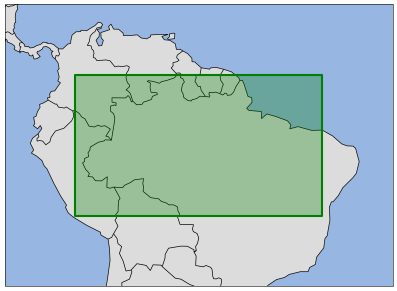

In [4]:
resolution = '110m'
map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-10,bounds[3]+10]
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[10,10], dpi=50)
ax = plt.subplot(111, projection=proj)
ax.set_extent(map_extent, box_proj)
# Add land, coastlines, borders to inset
ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
ax.add_feature(borders, edgecolor='k', facecolor='none')
ax.add_feature(states, edgecolor='k', facecolor='none')
# Plot a box region in the inset
box = sgeom.box(minx=bounds[0], maxx=bounds[1], miny=bounds[2], maxy=bounds[3])
ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=3)
ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

## Read track stats data, subset tracks, and get variables

In [5]:
# Read MCS track statistics file
dsw1 = xr.open_dataset(mcsfile_w1)
dsw2 = xr.open_dataset(mcsfile_w2)
dsw3 = xr.open_dataset(mcsfile_w3)
dsw1

<xarray.Dataset>
Dimensions:                  (tracks: 453, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 5 ... 448 449 450 451 452
  * times                    (times) int64 0 1 2 3 4 5 ... 395 396 397 398 399
  * mergers                  (mergers) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/60)
    track_duration           (tracks) int32 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] ...
    end_basetime             (tracks) datetime64[ns] ...
    start_split_cloudnumber  (tracks) float64 ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 ...
    movement_distance        (tracks, times) float32 ...
    movement_speed           (tracks, times) float32 ...
    movement_theta           (tracks, times) float32 ...
    movement_distance_x      (tracks, times) float32 ...
    movement_distance_y      (tracks, times) float32 ...
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Thu Jun 22 15:05:26 2023
    startdate:                   20140401.0000
    enddate:                     20140430.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

## Custom functions for track selections

In [6]:
def find_track_in_region(start_basetime, lons, lats, lifetime, lon_bounds, lat_bounds, lifetime_bounds, smonth_vals):
    """
    Find tracks within a region, lifetime, and month bounds.
    """
    # Get the track initiation month and location
    start_month = start_basetime.dt.month
    start_lon = lons.isel(times=0)
    start_lat = lats.isel(times=0)

    # Find tracks that initiates within a region
    mcsidx = np.where(
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds)) & \
        (np.in1d(start_month, smonth_vals))
    )[0]
    return mcsidx

def get_land_ocean_ds(ds, trackidx, land_frac_thresh, ocean_frac_thresh):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Subset tracks from Dataset
    ds = ds.isel(tracks=trackidx)

    # Calculate lifetime-mean PF land fraction
    init_landfrac = ds['pf_landfrac'].isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds['pf_landfrac'].mean(dim='times')
    # Separate land vs. ocean tracks
    mcsidx_land = np.where(avg_landfrac > land_frac_thresh)[0]
    mcsidx_ocean = np.where(avg_landfrac < ocean_frac_thresh)[0]
    # Subset tracks for land vs. ocean
    ds_l = ds.isel(tracks=mcsidx_land)
    ds_o = ds.isel(tracks=mcsidx_ocean)    
    return (ds_l, ds_o)

def find_merge_split_tracks(ds):
    """
    Find merge/split track indices.
    """
    # non-split tracks
    idx_nsplit = np.isnan(ds.start_split_cloudnumber)
    # non-merge tracks
    idx_nmerge = np.isnan(ds.end_merge_cloudnumber)
    # non-merge and non-split tracks
    idx_nms = np.isnan(ds.start_split_cloudnumber) & np.isnan(ds.end_merge_cloudnumber)
    # merge or split tracks
    idx_ms = ~np.isnan(ds.start_split_cloudnumber) | ~np.isnan(ds.end_merge_cloudnumber)
    # Group outputs to dictionary
    out_dict = {
        'ms': idx_ms,
        'nms': idx_nms,
        'nm': idx_nmerge,
        'ns': idx_nsplit,
    }
    return out_dict

In [7]:
# Get time resolution of data
time_res_w1 = dsw1.attrs['time_resolution_hour']
time_res_w2 = dsw2.attrs['time_resolution_hour']
time_res_w3 = dsw3.attrs['time_resolution_hour']
# Convert track duration to physical lifetime
lifetime_w1 = dsw1.track_duration * time_res_w1
lifetime_w2 = dsw2.track_duration * time_res_w2
lifetime_w3 = dsw3.track_duration * time_res_w3

# Subset MCS by region and lifetime
lon_bounds = [bounds[0],bounds[1]]
lat_bounds = [bounds[2],bounds[3]]
# lon_bounds, lat_bounds
idx_w1 = find_track_in_region(dsw1.start_basetime, dsw1.meanlon, dsw1.meanlat, lifetime_w1, lon_bounds, lat_bounds, lifetime_bounds, months)
print(f'Number of tracks (CTL): {len(idx_w1)}')
idx_w2 = find_track_in_region(dsw2.start_basetime, dsw2.meanlon, dsw2.meanlat, lifetime_w2, lon_bounds, lat_bounds, lifetime_bounds, months)
print(f'Number of tracks (HV10): {len(idx_w2)}')
idx_w3 = find_track_in_region(dsw3.start_basetime, dsw3.meanlon, dsw3.meanlat, lifetime_w3, lon_bounds, lat_bounds, lifetime_bounds, months)
print(f'Number of tracks (HV15): {len(idx_w3)}')

Number of tracks (CTL): 341
Number of tracks (HV10): 291
Number of tracks (HV15): 205


In [8]:
# Read WRF W statistics file
dsw_w1 = xr.open_dataset(Wfile_w1)
# height = dsw_w1.level
height = dsw_w1.level / 1000.  # Convert from [m] to [km]
dx = dsw_w1.attrs['DX']

# Subset tracks for W stats
dsw_w1 = dsw_w1.isel(tracks=idx_w1)

# Updraft
CoreAreaUp_mcsstage_w1 = dsw_w1['CoreArea_up'].where(dsw1['mcs_status'] == 1, drop=True)
CoreMaxWUp_mcsstage_w1 = dsw_w1['CoreMaxW_up'].where(dsw1['mcs_status'] == 1, drop=True)
nCoreUp_mcsstage_w1 = dsw_w1['nCore_up'].where(dsw1['mcs_status'] == 1, drop=True)
MassFluxUp_mcsstage_w1 = dsw_w1['MassFlux_up'].where(dsw1['mcs_status'] == 1, drop=True)
nsampleUp_mcsstage_w1 = CoreAreaUp_mcsstage_w1.where(~np.isnan(CoreAreaUp_mcsstage_w1)).count(dim=('tracks','times','core'))

# Downdraft
CoreAreaDn_mcsstage_w1 = dsw_w1['CoreArea_down'].where(dsw1['mcs_status'] == 1, drop=True)
CoreMinWDn_mcsstage_w1 = dsw_w1['CoreMinW_down'].where(dsw1['mcs_status'] == 1, drop=True)
nCoreDn_mcsstage_w1 = dsw_w1['nCore_down'].where(dsw1['mcs_status'] == 1, drop=True)
MassFluxDn_mcsstage_w1 = dsw_w1['MassFlux_down'].where(dsw1['mcs_status'] == 1, drop=True)
nsampleDn_mcsstage_w1 = CoreAreaDn_mcsstage_w1.where(~np.isnan(CoreAreaDn_mcsstage_w1)).count(dim=('tracks','times','core'))

In [9]:
# Read WRF W statistics file
dsw_w2 = xr.open_dataset(Wfile_w2)
# height = dsw_w2.level
dx = dsw_w2.attrs['DX']

# Subset tracks for W stats
dsw_w2 = dsw_w2.isel(tracks=idx_w2)

# Updraft
CoreAreaUp_mcsstage_w2 = dsw_w2['CoreArea_up'].where(dsw2['mcs_status'] == 1, drop=True)
CoreMaxWUp_mcsstage_w2 = dsw_w2['CoreMaxW_up'].where(dsw2['mcs_status'] == 1, drop=True)
nCoreUp_mcsstage_w2 = dsw_w2['nCore_up'].where(dsw2['mcs_status'] == 1, drop=True)
MassFluxUp_mcsstage_w2 = dsw_w2['MassFlux_up'].where(dsw2['mcs_status'] == 1, drop=True)
nsampleUp_mcsstage_w2 = CoreAreaUp_mcsstage_w2.where(~np.isnan(CoreAreaUp_mcsstage_w2)).count(dim=('tracks','times','core'))

# Downdraft
CoreAreaDn_mcsstage_w2 = dsw_w2['CoreArea_down'].where(dsw2['mcs_status'] == 1, drop=True)
CoreMinWDn_mcsstage_w2 = dsw_w2['CoreMinW_down'].where(dsw2['mcs_status'] == 1, drop=True)
nCoreDn_mcsstage_w2 = dsw_w2['nCore_down'].where(dsw2['mcs_status'] == 1, drop=True)
MassFluxDn_mcsstage_w2 = dsw_w2['MassFlux_down'].where(dsw2['mcs_status'] == 1, drop=True)
nsampleDn_mcsstage_w2 = CoreAreaDn_mcsstage_w2.where(~np.isnan(CoreAreaDn_mcsstage_w2)).count(dim=('tracks','times','core'))

In [10]:
# Read WRF W statistics file
dsw_w3 = xr.open_dataset(Wfile_w3)
# height = dsw_w3.level
dx = dsw_w3.attrs['DX']

# Subset tracks for W stats
dsw_w3 = dsw_w3.isel(tracks=idx_w3)

# Updraft
CoreAreaUp_mcsstage_w3 = dsw_w3['CoreArea_up'].where(dsw3['mcs_status'] == 1, drop=True)
CoreMaxWUp_mcsstage_w3 = dsw_w3['CoreMaxW_up'].where(dsw3['mcs_status'] == 1, drop=True)
nCoreUp_mcsstage_w3 = dsw_w3['nCore_up'].where(dsw3['mcs_status'] == 1, drop=True)
MassFluxUp_mcsstage_w3 = dsw_w3['MassFlux_up'].where(dsw3['mcs_status'] == 1, drop=True)
nsampleUp_mcsstage_w3 = CoreAreaUp_mcsstage_w3.where(~np.isnan(CoreAreaUp_mcsstage_w3)).count(dim=('tracks','times','core'))

# Downdraft
CoreAreaDn_mcsstage_w3 = dsw_w3['CoreArea_down'].where(dsw3['mcs_status'] == 1, drop=True)
CoreMinWDn_mcsstage_w3 = dsw_w3['CoreMinW_down'].where(dsw3['mcs_status'] == 1, drop=True)
nCoreDn_mcsstage_w3 = dsw_w3['nCore_down'].where(dsw3['mcs_status'] == 1, drop=True)
MassFluxDn_mcsstage_w3 = dsw_w3['MassFlux_down'].where(dsw3['mcs_status'] == 1, drop=True)
nsampleDn_mcsstage_w3 = CoreAreaDn_mcsstage_w3.where(~np.isnan(CoreAreaDn_mcsstage_w3)).count(dim=('tracks','times','core'))

## Calculate updraft/downdraft statistics

In [11]:
ncores = 5
min_ns = 20
quantiles = [0.25, 0.5, 0.75]

# Updrafts
CoreAreaUp_mcsstage_avg_w1 = CoreAreaUp_mcsstage_w1.sel(core=slice(0,ncores-1)).mean(dim=('tracks','times','core')).load()
CoreAreaUp_mcsstage_pts_w1 = CoreAreaUp_mcsstage_w1.sel(core=slice(0,ncores-1)).quantile(q=quantiles, dim=('tracks','times','core')).load()

CoreMaxWUp_mcsstage_avg_w1 = CoreMaxWUp_mcsstage_w1.sel(core=slice(0,ncores-1)).mean(dim=('tracks','times','core')).load()
CoreMaxWUp_mcsstage_pts_w1 = CoreMaxWUp_mcsstage_w1.sel(core=slice(0,ncores-1)).quantile(q=quantiles, dim=('tracks','times','core')).load()

nCoreUp_mcsstage_avg_w1 = nCoreUp_mcsstage_w1.mean(dim=('tracks','times')).load()
nCoreUp_mcsstage_pts_w1 = nCoreUp_mcsstage_w1.quantile(q=quantiles, dim=('tracks','times')).load()

MassFluxUp_mcsstage_avg_w1 = MassFluxUp_mcsstage_w1.mean(dim=('tracks','times')).load()
MassFluxUp_mcsstage_pts_w1 = MassFluxUp_mcsstage_w1.quantile(q=quantiles, dim=('tracks','times')).load()

# Downdrafts
CoreAreaDn_mcsstage_avg_w1 = CoreAreaDn_mcsstage_w1.sel(core=slice(0,ncores-1)).mean(dim=('tracks','times','core')).load()
CoreAreaDn_mcsstage_pts_w1 = CoreAreaDn_mcsstage_w1.sel(core=slice(0,ncores-1)).quantile(q=quantiles, dim=('tracks','times','core')).load()

CoreMinWDn_mcsstage_avg_w1 = CoreMinWDn_mcsstage_w1.sel(core=slice(0,ncores-1)).mean(dim=('tracks','times','core')).load()
CoreMinWDn_mcsstage_pts_w1 = CoreMinWDn_mcsstage_w1.sel(core=slice(0,ncores-1)).quantile(q=quantiles, dim=('tracks','times','core')).load()

nCoreDn_mcsstage_avg_w1 = nCoreDn_mcsstage_w1.mean(dim=('tracks','times')).load()
nCoreDn_mcsstage_pts_w1 = nCoreDn_mcsstage_w1.quantile(q=quantiles, dim=('tracks','times')).load()

MassFluxDn_mcsstage_avg_w1 = MassFluxDn_mcsstage_w1.mean(dim=('tracks','times')).load()
MassFluxDn_mcsstage_pts_w1 = MassFluxDn_mcsstage_w1.quantile(q=quantiles, dim=('tracks','times')).load()

# Filter heights where sample size is too small
CoreAreaUp_mcsstage_avg_w1 = CoreAreaUp_mcsstage_avg_w1.where(nsampleUp_mcsstage_w1 > min_ns)
CoreAreaUp_mcsstage_pts_w1 = CoreAreaUp_mcsstage_pts_w1.where(nsampleUp_mcsstage_w1 > min_ns)

CoreMaxWUp_mcsstage_avg_w1 = CoreMaxWUp_mcsstage_avg_w1.where(nsampleUp_mcsstage_w1 > min_ns)
CoreMaxWUp_mcsstage_pts_w1 = CoreMaxWUp_mcsstage_pts_w1.where(nsampleUp_mcsstage_w1 > min_ns)

nCoreUp_mcsstage_avg_w1 = nCoreUp_mcsstage_avg_w1.where(nsampleUp_mcsstage_w1 > min_ns)
nCoreUp_mcsstage_pts_w1 = nCoreUp_mcsstage_pts_w1.where(nsampleUp_mcsstage_w1 > min_ns)

MassFluxUp_mcsstage_avg_w1 = MassFluxUp_mcsstage_avg_w1.where(nsampleUp_mcsstage_w1 > min_ns)
MassFluxUp_mcsstage_pts_w1 = MassFluxUp_mcsstage_pts_w1.where(nsampleUp_mcsstage_w1 > min_ns)

# Filter heights where sample size is too small
CoreAreaDn_mcsstage_avg_w1 = CoreAreaDn_mcsstage_avg_w1.where(nsampleDn_mcsstage_w1 > min_ns)
CoreAreaDn_mcsstage_pts_w1 = CoreAreaDn_mcsstage_pts_w1.where(nsampleDn_mcsstage_w1 > min_ns)

CoreMinWDn_mcsstage_avg_w1 = CoreMinWDn_mcsstage_avg_w1.where(nsampleDn_mcsstage_w1 > min_ns)
CoreMinWDn_mcsstage_pts_w1 = CoreMinWDn_mcsstage_pts_w1.where(nsampleDn_mcsstage_w1 > min_ns)

nCoreDn_mcsstage_avg_w1 = nCoreDn_mcsstage_avg_w1.where(nsampleDn_mcsstage_w1 > min_ns)
nCoreDn_mcsstage_pts_w1 = nCoreDn_mcsstage_pts_w1.where(nsampleDn_mcsstage_w1 > min_ns)

MassFluxDn_mcsstage_avg_w1 = MassFluxDn_mcsstage_avg_w1.where(nsampleDn_mcsstage_w1 > min_ns)
MassFluxDn_mcsstage_pts_w1 = MassFluxDn_mcsstage_pts_w1.where(nsampleDn_mcsstage_w1 > min_ns)

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [12]:
# Updrafts
CoreAreaUp_mcsstage_avg_w2 = CoreAreaUp_mcsstage_w2.sel(core=slice(0,ncores-1)).mean(dim=('tracks','times','core')).load()
CoreAreaUp_mcsstage_pts_w2 = CoreAreaUp_mcsstage_w2.sel(core=slice(0,ncores-1)).quantile(q=quantiles, dim=('tracks','times','core')).load()

CoreMaxWUp_mcsstage_avg_w2 = CoreMaxWUp_mcsstage_w2.sel(core=slice(0,ncores-1)).mean(dim=('tracks','times','core')).load()
CoreMaxWUp_mcsstage_pts_w2 = CoreMaxWUp_mcsstage_w2.sel(core=slice(0,ncores-1)).quantile(q=quantiles, dim=('tracks','times','core')).load()

nCoreUp_mcsstage_avg_w2 = nCoreUp_mcsstage_w2.mean(dim=('tracks','times')).load()
nCoreUp_mcsstage_pts_w2 = nCoreUp_mcsstage_w2.quantile(q=quantiles, dim=('tracks','times')).load()

MassFluxUp_mcsstage_avg_w2 = MassFluxUp_mcsstage_w2.mean(dim=('tracks','times')).load()
MassFluxUp_mcsstage_pts_w2 = MassFluxUp_mcsstage_w2.quantile(q=quantiles, dim=('tracks','times')).load()

# Downdrafts
CoreAreaDn_mcsstage_avg_w2 = CoreAreaDn_mcsstage_w2.sel(core=slice(0,ncores-1)).mean(dim=('tracks','times','core')).load()
CoreAreaDn_mcsstage_pts_w2 = CoreAreaDn_mcsstage_w2.sel(core=slice(0,ncores-1)).quantile(q=quantiles, dim=('tracks','times','core')).load()

CoreMinWDn_mcsstage_avg_w2 = CoreMinWDn_mcsstage_w2.sel(core=slice(0,ncores-1)).mean(dim=('tracks','times','core')).load()
CoreMinWDn_mcsstage_pts_w2 = CoreMinWDn_mcsstage_w2.sel(core=slice(0,ncores-1)).quantile(q=quantiles, dim=('tracks','times','core')).load()

nCoreDn_mcsstage_avg_w2 = nCoreDn_mcsstage_w2.mean(dim=('tracks','times')).load()
nCoreDn_mcsstage_pts_w2 = nCoreDn_mcsstage_w2.quantile(q=quantiles, dim=('tracks','times')).load()

MassFluxDn_mcsstage_avg_w2 = MassFluxDn_mcsstage_w2.mean(dim=('tracks','times')).load()
MassFluxDn_mcsstage_pts_w2 = MassFluxDn_mcsstage_w2.quantile(q=quantiles, dim=('tracks','times')).load()

# Filter heights where sample size is too small
CoreAreaUp_mcsstage_avg_w2 = CoreAreaUp_mcsstage_avg_w2.where(nsampleUp_mcsstage_w2 > min_ns)
CoreAreaUp_mcsstage_pts_w2 = CoreAreaUp_mcsstage_pts_w2.where(nsampleUp_mcsstage_w2 > min_ns)

CoreMaxWUp_mcsstage_avg_w2 = CoreMaxWUp_mcsstage_avg_w2.where(nsampleUp_mcsstage_w2 > min_ns)
CoreMaxWUp_mcsstage_pts_w2 = CoreMaxWUp_mcsstage_pts_w2.where(nsampleUp_mcsstage_w2 > min_ns)

nCoreUp_mcsstage_avg_w2 = nCoreUp_mcsstage_avg_w2.where(nsampleUp_mcsstage_w2 > min_ns)
nCoreUp_mcsstage_pts_w2 = nCoreUp_mcsstage_pts_w2.where(nsampleUp_mcsstage_w2 > min_ns)

MassFluxUp_mcsstage_avg_w2 = MassFluxUp_mcsstage_avg_w2.where(nsampleUp_mcsstage_w2 > min_ns)
MassFluxUp_mcsstage_pts_w2 = MassFluxUp_mcsstage_pts_w2.where(nsampleUp_mcsstage_w2 > min_ns)

# Filter heights where sample size is too small
CoreAreaDn_mcsstage_avg_w2 = CoreAreaDn_mcsstage_avg_w2.where(nsampleDn_mcsstage_w2 > min_ns)
CoreAreaDn_mcsstage_pts_w2 = CoreAreaDn_mcsstage_pts_w2.where(nsampleDn_mcsstage_w2 > min_ns)

CoreMinWDn_mcsstage_avg_w2 = CoreMinWDn_mcsstage_avg_w2.where(nsampleDn_mcsstage_w2 > min_ns)
CoreMinWDn_mcsstage_pts_w2 = CoreMinWDn_mcsstage_pts_w2.where(nsampleDn_mcsstage_w2 > min_ns)

nCoreDn_mcsstage_avg_w2 = nCoreDn_mcsstage_avg_w2.where(nsampleDn_mcsstage_w2 > min_ns)
nCoreDn_mcsstage_pts_w2 = nCoreDn_mcsstage_pts_w2.where(nsampleDn_mcsstage_w2 > min_ns)

MassFluxDn_mcsstage_avg_w2 = MassFluxDn_mcsstage_avg_w2.where(nsampleDn_mcsstage_w2 > min_ns)
MassFluxDn_mcsstage_pts_w2 = MassFluxDn_mcsstage_pts_w2.where(nsampleDn_mcsstage_w2 > min_ns)

In [13]:
# Updrafts
CoreAreaUp_mcsstage_avg_w3 = CoreAreaUp_mcsstage_w3.sel(core=slice(0,ncores-1)).mean(dim=('tracks','times','core')).load()
CoreAreaUp_mcsstage_pts_w3 = CoreAreaUp_mcsstage_w3.sel(core=slice(0,ncores-1)).quantile(q=quantiles, dim=('tracks','times','core')).load()

CoreMaxWUp_mcsstage_avg_w3 = CoreMaxWUp_mcsstage_w3.sel(core=slice(0,ncores-1)).mean(dim=('tracks','times','core')).load()
CoreMaxWUp_mcsstage_pts_w3 = CoreMaxWUp_mcsstage_w3.sel(core=slice(0,ncores-1)).quantile(q=quantiles, dim=('tracks','times','core')).load()

nCoreUp_mcsstage_avg_w3 = nCoreUp_mcsstage_w3.mean(dim=('tracks','times')).load()
nCoreUp_mcsstage_pts_w3 = nCoreUp_mcsstage_w3.quantile(q=quantiles, dim=('tracks','times')).load()

MassFluxUp_mcsstage_avg_w3 = MassFluxUp_mcsstage_w3.mean(dim=('tracks','times')).load()
MassFluxUp_mcsstage_pts_w3 = MassFluxUp_mcsstage_w3.quantile(q=quantiles, dim=('tracks','times')).load()

# Downdrafts
CoreAreaDn_mcsstage_avg_w3 = CoreAreaDn_mcsstage_w3.sel(core=slice(0,ncores-1)).mean(dim=('tracks','times','core')).load()
CoreAreaDn_mcsstage_pts_w3 = CoreAreaDn_mcsstage_w3.sel(core=slice(0,ncores-1)).quantile(q=quantiles, dim=('tracks','times','core')).load()

CoreMinWDn_mcsstage_avg_w3 = CoreMinWDn_mcsstage_w3.sel(core=slice(0,ncores-1)).mean(dim=('tracks','times','core')).load()
CoreMinWDn_mcsstage_pts_w3 = CoreMinWDn_mcsstage_w3.sel(core=slice(0,ncores-1)).quantile(q=quantiles, dim=('tracks','times','core')).load()

nCoreDn_mcsstage_avg_w3 = nCoreDn_mcsstage_w3.mean(dim=('tracks','times')).load()
nCoreDn_mcsstage_pts_w3 = nCoreDn_mcsstage_w3.quantile(q=quantiles, dim=('tracks','times')).load()

MassFluxDn_mcsstage_avg_w3 = MassFluxDn_mcsstage_w3.mean(dim=('tracks','times')).load()
MassFluxDn_mcsstage_pts_w3 = MassFluxDn_mcsstage_w3.quantile(q=quantiles, dim=('tracks','times')).load()

# Filter heights where sample size is too small
CoreAreaUp_mcsstage_avg_w3 = CoreAreaUp_mcsstage_avg_w3.where(nsampleUp_mcsstage_w3 > min_ns)
CoreAreaUp_mcsstage_pts_w3 = CoreAreaUp_mcsstage_pts_w3.where(nsampleUp_mcsstage_w3 > min_ns)

CoreMaxWUp_mcsstage_avg_w3 = CoreMaxWUp_mcsstage_avg_w3.where(nsampleUp_mcsstage_w3 > min_ns)
CoreMaxWUp_mcsstage_pts_w3 = CoreMaxWUp_mcsstage_pts_w3.where(nsampleUp_mcsstage_w3 > min_ns)

nCoreUp_mcsstage_avg_w3 = nCoreUp_mcsstage_avg_w3.where(nsampleUp_mcsstage_w3 > min_ns)
nCoreUp_mcsstage_pts_w3 = nCoreUp_mcsstage_pts_w3.where(nsampleUp_mcsstage_w3 > min_ns)

MassFluxUp_mcsstage_avg_w3 = MassFluxUp_mcsstage_avg_w3.where(nsampleUp_mcsstage_w3 > min_ns)
MassFluxUp_mcsstage_pts_w3 = MassFluxUp_mcsstage_pts_w3.where(nsampleUp_mcsstage_w3 > min_ns)

# Filter heights where sample size is too small
CoreAreaDn_mcsstage_avg_w3 = CoreAreaDn_mcsstage_avg_w3.where(nsampleDn_mcsstage_w3 > min_ns)
CoreAreaDn_mcsstage_pts_w3 = CoreAreaDn_mcsstage_pts_w3.where(nsampleDn_mcsstage_w3 > min_ns)

CoreMinWDn_mcsstage_avg_w3 = CoreMinWDn_mcsstage_avg_w3.where(nsampleDn_mcsstage_w3 > min_ns)
CoreMinWDn_mcsstage_pts_w3 = CoreMinWDn_mcsstage_pts_w3.where(nsampleDn_mcsstage_w3 > min_ns)

nCoreDn_mcsstage_avg_w3 = nCoreDn_mcsstage_avg_w3.where(nsampleDn_mcsstage_w3 > min_ns)
nCoreDn_mcsstage_pts_w3 = nCoreDn_mcsstage_pts_w3.where(nsampleDn_mcsstage_w3 > min_ns)

MassFluxDn_mcsstage_avg_w3 = MassFluxDn_mcsstage_avg_w3.where(nsampleDn_mcsstage_w3 > min_ns)
MassFluxDn_mcsstage_pts_w3 = MassFluxDn_mcsstage_pts_w3.where(nsampleDn_mcsstage_w3 > min_ns)

## Function to plot profiles in 4 panels

In [14]:
def plot_profiles_4panels(height, quantiles, avg_w1, avg_w2, avg_w3, pts_w1, pts_w2, pts_w3,
                          titles, xlabels, ylabels, figname, 
                          xlims=None, ylims=None, yticks=None, legend=None, labels=None):
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=[16,6], dpi=100)

    colors = {'w1':'k','w2':'dodgerblue', 'w3':'tomato'}

    for col in range(0,4): 
        ax = axes[col]
        ax.plot(avg_w1[col], height, colors['w1'], lw=5, label=labels['w1'])
        ax.plot(avg_w2[col], height, colors['w2'], lw=5, label=labels['w2'])
        ax.plot(avg_w3[col], height, colors['w3'], lw=5, label=labels['w3'])
        ax.fill_betweenx(height, pts_w1[col].sel(quantile=0.25), pts_w1[col].sel(quantile=0.75), facecolor=colors['w1'], alpha=0.35)
        ax.fill_betweenx(height, pts_w2[col].sel(quantile=0.25), pts_w2[col].sel(quantile=0.75), facecolor=colors['w2'], alpha=0.35)
        ax.fill_betweenx(height, pts_w3[col].sel(quantile=0.25), pts_w3[col].sel(quantile=0.75), facecolor=colors['w3'], alpha=0.35)
        if (col == 0):
            ax.legend(fontsize=14, loc='upper right')
        ax.grid(which='major', ls='--')
        ax.set_title(titles[col], loc='left')
        ax.set_xlabel(xlabels[col])
        ax.set_ylabel(ylabels[col])
        # ax.set_ylim(0, 14)
        # ax.set_yticks(np.arange(0, 14.1, 2))
        ax.axvline(0, color='k', ls='--', lw=2)
        if xlims is not None:
            ax.set_xlim(xlims[col][0], xlims[col][1])
        if ylims is not None:
            ax.set_ylim(ylims[0], ylims[1])
        if yticks is not None:
            ax.set_yticks(yticks)
        if (legend is not None) & (col == 0):
            ax.text(0.95, 0.05, legend, ha='right', va='center', transform=ax.transAxes)

    fig.tight_layout(w_pad=1, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

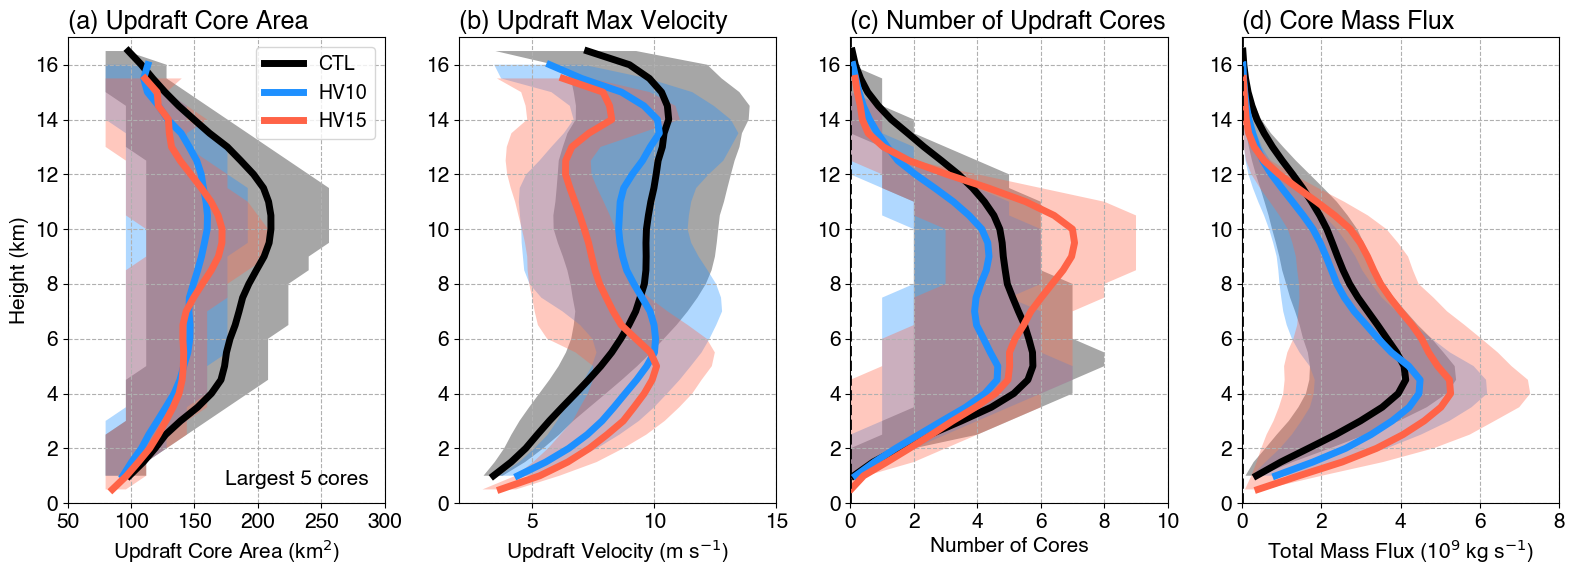

In [15]:
MFpower = 9
MFscale = 10**(MFpower)
avg_w1 = [CoreAreaUp_mcsstage_avg_w1, CoreMaxWUp_mcsstage_avg_w1, nCoreUp_mcsstage_avg_w1, MassFluxUp_mcsstage_avg_w1/MFscale]
avg_w2 = [CoreAreaUp_mcsstage_avg_w2, CoreMaxWUp_mcsstage_avg_w2, nCoreUp_mcsstage_avg_w2, MassFluxUp_mcsstage_avg_w2/MFscale]
avg_w3 = [CoreAreaUp_mcsstage_avg_w3, CoreMaxWUp_mcsstage_avg_w3, nCoreUp_mcsstage_avg_w3, MassFluxUp_mcsstage_avg_w3/MFscale]
pts_w1 = [CoreAreaUp_mcsstage_pts_w1, CoreMaxWUp_mcsstage_pts_w1, nCoreUp_mcsstage_pts_w1, MassFluxUp_mcsstage_pts_w1/MFscale]
pts_w2 = [CoreAreaUp_mcsstage_pts_w2, CoreMaxWUp_mcsstage_pts_w2, nCoreUp_mcsstage_pts_w2, MassFluxUp_mcsstage_pts_w2/MFscale]
pts_w3 = [CoreAreaUp_mcsstage_pts_w3, CoreMaxWUp_mcsstage_pts_w3, nCoreUp_mcsstage_pts_w3, MassFluxUp_mcsstage_pts_w3/MFscale]

labels = {'w1':'CTL', 'w2':'HV10', 'w3':'HV15'}
titles = ['(a) Updraft Core Area', '(b) Updraft Max Velocity', '(c) Number of Updraft Cores', '(d) Core Mass Flux']
xlabels = ['Updraft Core Area (km$^2$)','Updraft Velocity (m s$^{-1}$)','Number of Cores', f'Total Mass Flux (10$^{MFpower}$'+' kg s$^{-1}$)']
ylabels = ['Height (km)','','','']
xlims = [(50,300), (2,15), (0,10), (0,8)]
ylims = (0, 17)
yticks = np.arange(0, 16.1, 2)
legend = f'Largest {ncores} cores'
figname = f'{figdir}MCS_Updraft_CoreArea_Wmax_nCores_MassFlux_MCSstage_wrf.png'
fig = plot_profiles_4panels(height, quantiles, avg_w1, avg_w2, avg_w3, pts_w1, pts_w2, pts_w3,
                           titles, xlabels, ylabels, figname, xlims=xlims, ylims=ylims, yticks=yticks, legend=legend, labels=labels)

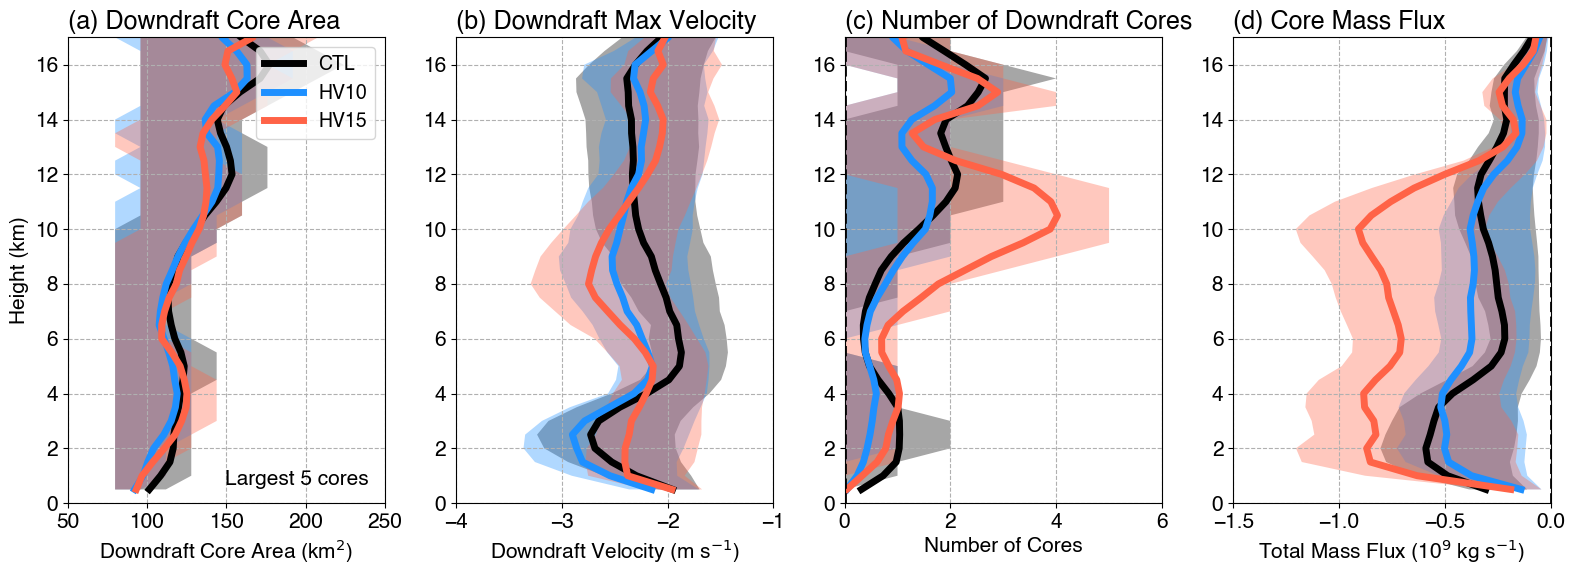

In [16]:
MFpower = 9
MFscale = 10**(MFpower)
avg_w1 = [CoreAreaDn_mcsstage_avg_w1, CoreMinWDn_mcsstage_avg_w1, nCoreDn_mcsstage_avg_w1, MassFluxDn_mcsstage_avg_w1/MFscale]
avg_w2 = [CoreAreaDn_mcsstage_avg_w2, CoreMinWDn_mcsstage_avg_w2, nCoreDn_mcsstage_avg_w2, MassFluxDn_mcsstage_avg_w2/MFscale]
avg_w3 = [CoreAreaDn_mcsstage_avg_w3, CoreMinWDn_mcsstage_avg_w3, nCoreDn_mcsstage_avg_w3, MassFluxDn_mcsstage_avg_w3/MFscale]
pts_w1 = [CoreAreaDn_mcsstage_pts_w1, CoreMinWDn_mcsstage_pts_w1, nCoreDn_mcsstage_pts_w1, MassFluxDn_mcsstage_pts_w1/MFscale]
pts_w2 = [CoreAreaDn_mcsstage_pts_w2, CoreMinWDn_mcsstage_pts_w2, nCoreDn_mcsstage_pts_w2, MassFluxDn_mcsstage_pts_w2/MFscale]
pts_w3 = [CoreAreaDn_mcsstage_pts_w3, CoreMinWDn_mcsstage_pts_w3, nCoreDn_mcsstage_pts_w3, MassFluxDn_mcsstage_pts_w3/MFscale]

labels = {'w1':'CTL', 'w2':'HV10', 'w3':'HV15'}
titles = ['(a) Downdraft Core Area', '(b) Downdraft Max Velocity', '(c) Number of Downdraft Cores', '(d) Core Mass Flux']
xlabels = [f'Downdraft Core Area (km$^2$)','Downdraft Velocity (m s$^{-1}$)','Number of Cores', f'Total Mass Flux (10$^{MFpower}$'+' kg s$^{-1}$)']
ylabels = ['Height (km)','','','']
xlims = [(50,250), (-4,-1), (0,6), (-1.5,0)]
ylims = (0, 17)
yticks = np.arange(0, 16.1, 2)
legend = f'Largest {ncores} cores'
figname = f'{figdir}MCS_Downdraft_CoreArea_Wmin_nCores_MassFlux_MCSstage_wrf.png'
fig = plot_profiles_4panels(height, quantiles, avg_w1, avg_w2, avg_w3, pts_w1, pts_w2, pts_w3,
                           titles, xlabels, ylabels, figname, xlims=xlims, ylims=ylims, yticks=yticks, legend=legend, labels=labels)

In [17]:
figdir

'/global/cfs/cdirs/m1657/zfeng/amazon_hvmixing/figures_test/'